# Esperienza Microonde

### Utility per propagazione errore

In [2]:
import sympy 
import numpy as np

def generate_error_propagation(function, variables):
    symbols = sympy.symbols(variables)
    cov_symbols = sympy.symbols(' '.join([f'cov_{i}' for i in range(len(variables))]))
    sum_diff = sympy.sqrt(sum(function.diff(s) ** 2 * c for s, c in zip(symbols, cov_symbols)))
    sum_diff = sum_diff.simplify()

    values = sympy.lambdify(symbols, function)
    covariance = sympy.lambdify(symbols + cov_symbols, sum_diff)

    def fn(**kwargs):
        x = tuple(v[0] for v in kwargs.values())
        c = tuple(v[1] for v in kwargs.values())
        return values(*x), covariance(*x, *c)

    return fn

def error_propagation(function, **kwargs):
    value, error = generate_error_propagation(function, tuple(kwargs))(**kwargs)
    return value, error

# test
x, y = sympy.symbols('x y')
f = x + y
print(error_propagation(f, x=(1, 0.1), y=(2, 0.1)))

(3, 0.4472135954999579)


## Caratterizzazione del fascio

### Legge di Malus / Polarizzazione

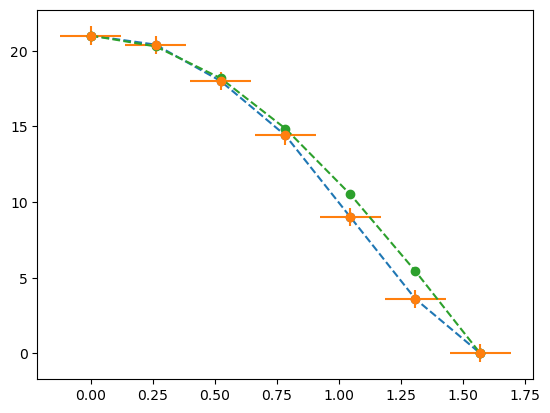

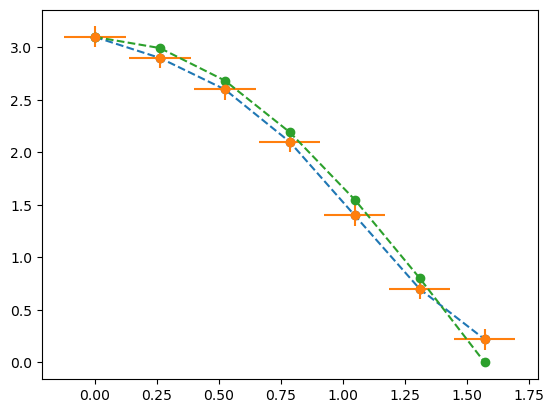

In [3]:
import numpy as np

theta = [0, 15, 30, 45, 60, 75, 90]
err_theta = 5 # gradi per un singoo ricervitore/trasmittore
err_totale = np.radians(np.sqrt(5**2+5**2))

# amperaggio mA x 30
M = [0.7, 0.68, 0.6, 0.48, 0.3, 0.12, 0] # * 30
err_M = .02 * 30
# voltmetro
V = [3.1, 2.9, 2.6, 2.1, 1.4, 0.7, 0.22]
err_V = [0.1, 0.01, 0.01, 0.01, 0.01, 0.01]

# plot data of cos(theta) with M and V
import matplotlib.pyplot as plt
plt.plot(np.radians(theta), np.array(M)*30, 'o--')
plt.errorbar(np.radians(theta), np.array(M)*30, yerr=err_M, xerr=err_totale, fmt='o')
# plot M[0]*30 * cos(theta)
plt.plot(np.radians(theta), M[0]*30 * np.cos(np.radians(theta)), 'o--')
plt.show()

# plot data of cos(theta) with V
plt.plot(np.radians(theta), V, 'o--')
plt.errorbar(np.radians(theta), V, yerr=0.1, xerr=err_totale, fmt='o')
# plot V[0] * cos(theta)
plt.plot(np.radians(theta), V[0] * np.cos(np.radians(theta)), 'o--')
plt.show()

### Ampiezza

1. Studiare dipendenza ampiezza dall'angolo
2. Studiare dipendenza ampiezza dalla distanza

<ErrorbarContainer object of 3 artists>

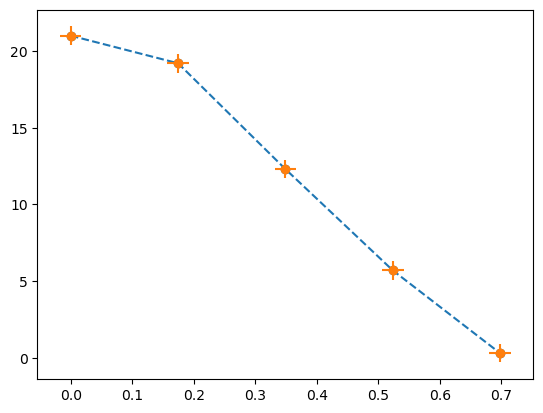

In [4]:
r_i = 101.7 # cm

# Punto 1
theta = [0, 10, 20, 30, 40]
M = [0.7, 0.64, 0.41, 0.19, 0.01] #x30

plt.plot(np.radians(theta), np.array(M)*30, 'o--')
plt.errorbar(np.radians(theta), np.array(M)*30, yerr=err_M, xerr=np.radians(1), fmt='o')



((array([0.67075, 0.64225, 0.61375, 0.58525, 0.55675, 0.52825, 0.49975,
         0.47125]),
  array([16.8, 17.4, 18. , 19.2, 20.4, 21. , 21.6, 23.4]),
  array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6])),
 (array([0.47125   , 0.48371875, 0.4961875 , 0.50865625, 0.521125  ,
         0.53359375, 0.5460625 , 0.55853125, 0.571     , 0.5959375 ,
         0.620875  , 0.6458125 , 0.67075   ]),
  array([23.56050263, 22.95318687, 22.37639373, 21.82787858, 21.30561164,
         20.80775283, 20.33263017, 19.87872096, 19.44463549, 18.63095855,
         17.88264444, 17.19212134, 16.55294352])))

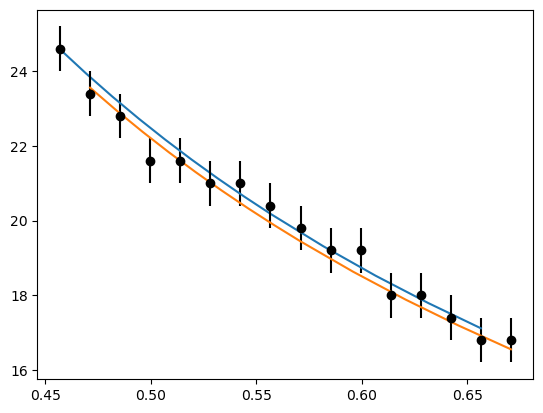

In [5]:
# confronto fit 1/r, 1/r^2
import iminuit as m
from iminuit import Minuit
from iminuit.cost import LeastSquares

# misura delle distanze fatte considerando ogni lunghezza d'onda per avere gli stessi massimi

lambda_ = 2.85 # cm

# misura amperometro
d_max = (81 - 12.5 - lambda_   * np.array([1, 2, 3, 4, 5, 6, 7, 8])) * 0.01
d_min = (81 - 12.5 - lambda_/2 * np.array([1, 3, 5, 7, 9, 11, 13, 15])) * 0.01
err_d = 0.005
M_max = np.array([0.56, 0.6, 0.64, 0.66, 0.7, 0.72, 0.76, 0.82]) * 30
M_min = np.array([0.56, 0.58, 0.6, 0.64, 0.68, 0.7, 0.72, 0.78]) * 30
err_M = 0.02 * 30
# trasform err_M in vector with 8 same vlaues
err_M = np.array([err_M] * 8)

V_max = np.array([2.4, 2.6, 2.8, 2.9, 3.1, 3.2, 3.3, 3.7])
V_min = np.array([2.4, 2.5, 2.6, 2.8, 3, 3.1, 3.2, 3.5])
err_V = 0.1

def model(x, a):
    return a/x 

minimi_quadrati = LeastSquares(d_max, M_max, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
#display(m)
m.visualize()

minimi_quadrati = LeastSquares(d_min, M_min, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
#display(m)
m.visualize()

### Geometria

In [6]:
# parliamo pure della orientazione della polarizzazione
# verticale per avere valore minimo di amperaggio

## Angolo di Brewster

In [7]:
def model(x, a):
    return a*x**2

theta = np.radians([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 47, 57, 23, \
                    27, 33, 37, 43, 53, 63])
M = np.array([0.50, 0.52, 0.56, 0.6, 0.66, 0.67, 0.7, 0.62, 0.48, 0.42, \
              0.680, 0.6, 0.52, 0.54, 0.6, 0.62, 0.68, 0.68, 0.44]) * 30
V = np.array([2.2, 2.3, 2.5, 2.7, 2.9, 3, 3.1, 2.7, 2.1, 1.9, 3.0, 2.6, \
              2.3, 2.4, 2.6, 2.8, 3, 3, 1.9])

sorted_indices = sorted(range(len(theta)), key=lambda i: theta[i])

theta = np.array(theta)[sorted_indices]
M = M[sorted_indices]
V = V[sorted_indices]

err_M = 0.02 * 30
err_M = np.array([err_M] * len(M))

def model(x, a, b, c):
    return c + b*x + a * x**2

minimi_quadrati = LeastSquares(theta[2:16], M[2:16], err_M[2:16], model)

m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.figure()
angolo_wurstel = -m.values["b"]/(2*m.values["a"])
print(angolo_wurstel, np.degrees(angolo_wurstel))
print(m.ndof)

minimi_quadrati = LeastSquares(theta[2:16], V[2:16], 0.1, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)
m.migrad()
m.hesse()
display(m)

angolo_wurstel = -m.values["b"]/(2*m.values["a"])
print(angolo_wurstel, np.degrees(angolo_wurstel))
print(m.ndof)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.11 (χ²/ndof = 1.1)      │              Nfcn = 84               │
│ EDM = 1.94e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    -38    │     6     │            │            │         │         │       │
│ 1 │ b    │    61     │     8     │            │            │         │         │       │
│ 2 │ c    │   -4.5    │    2.9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────┐
│   │    a    b    c │
├───┼────────────────┤
│ a │ 34.5  -49   17 │
│ b │  -49 71.8  -25 │
│ c │   17  -25 8.53 │
└───┴────────────────┘

0.803075506740323 46.012837166550405
11.0


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.28 (χ²/ndof = 0.9)      │              Nfcn = 86               │
│ EDM = 2.75e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -6.1    │    1.0    │            │            │         │         │       │
│ 1 │ b    │    9.7    │    1.4    │            │            │         │         │       │
│ 2 │ c    │   -0.8    │    0.5    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │     a     b     c │
├───┼───────────────────┤
│ a │ 0.965  -1.4  0.47 │
│ b │  -1.4  2.01 -0.69 │
│ c │  0.47 -0.69 0.239 │
└───┴───────────────────┘

0.7900355058587822 45.26570015119125
11.0


<Figure size 640x480 with 0 Axes>

## Interferenza

Studiare almeno due casi (per la valutazione ne vengono utilizzati due)

#### Fabry-Perot


Emettitore e ricevitore verticali

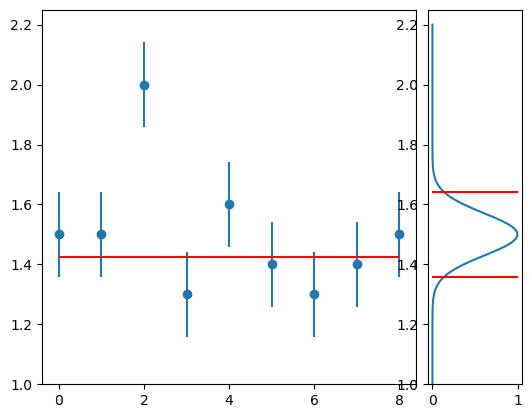

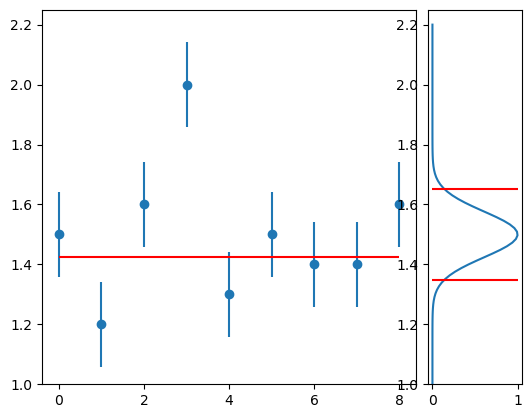

In [61]:
d_fissa = 80 #cm, non serve aumenta l'errore

#errore sistematico spessore lastre si cancella
d_min = np.array([24, 25.5, 27, 29, 30.3, 31.9, 33.3, 34.6, 36, 37.5]) #cm
d_max = np.array([23.5, 25, 26.2, 27.8, 29.8, 31.1, 32.6, 34, 35.4, 37]) #cm
err_d = 0.1 * np.sqrt(2) #cm

# create a vector difference of values between d_min[n+1] - d_min[n]
delta_d_min = np.diff(d_min)
# create a vector difference of values between d_max[n+1] - d_max[n]
delta_d_max = np.diff(d_max)

# rewrite all in a function
def plot_meas_with_gauss(delta_d, err_d, mean, std):
    fig = plt.figure(figsize=(6, 6))

    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1, 0])
    ax_ploty = fig.add_subplot(gs[1, 1], sharey=ax)

    ax.errorbar(range(9), delta_d, yerr=err_d, fmt='o')
    ax.hlines(1.425,0,8,color='r')
    ax.plot()
    x = np.linspace(1, 2.2, 100)
    ax_ploty.plot(np.exp(-0.5*((x-mean)/std)**2), x)
    ax_ploty.set_ylim(1, 2.25)
    ax_ploty.hlines([mean-2*std, mean+2*std], 0, 1, color='r')

mean_min = np.mean(delta_d_min)
std_min = np.std(delta_d_min, ddof=1)/np.sqrt(len(delta_d_min))
plot_meas_with_gauss(delta_d_min, err_d, mean_min, std_min)

mean_max = np.mean(delta_d_max)
std_max = np.std(delta_d_max, ddof=1)/np.sqrt(len(delta_d_max))
plot_meas_with_gauss(delta_d_max, err_d, mean_max, std_max)

#### Doppia fenditura

Emettitore e ricevitore verticali

In [9]:
theta_min = np.radians([6, ])
theta_max = np.radians([0, 12])
err_theta = np.radians(1)

d = 17 # cm
err_d = 0.2

lambda_ = 2.85 # cm

n = d*np.sin(theta_max) / lambda_
print(n)

n = (2 * d*np.sin(theta_min) / lambda_ - 1) / 2
print(n)

[0.       1.240175]
[0.12350311]


## Diffrazione di Bragg

In [10]:
# write equation in sympy
# n*lambda = 2*d*sin(alfa)
n, lambda_, d, theta = sympy.symbols('n λ d θ')
eq = sympy.Eq(n * lambda_, 2 * d * sympy.sin(theta))
eq

Eq(n*λ, 2*d*sin(θ))